# **[PlantVillage Disease Classification Challenge](https://www.crowdai.org/challenges/plantvillage-disease-classification-challenge)**

PlantVillage is built on the premise that all knowledge that helps people grow food should be openly accessible to anyone on the planet.

**Overview**

We depend on edible plants just as we depend on oxygen. Without crops, there is no food, and without food, there is no life. It's no accident that human civilization began to thrive with the invention of agriculture.

Today, modern technology allows us to grow crops in quantities necessary for a steady food supply for billions of people. But diseases remain a major threat to this supply, and a large fraction of crops are lost each year to diseases. The situation is particularly dire for the 500 million smallholder farmers around the globe, whose livelihoods depend on their crops doing well. In Africa alone, 80% of the agricultural output comes from smallholder farmers.

With billions of smartphones around the globe, wouldn't it be great if the smartphone could be turned into a disease diagnostics tool, recognizing diseases from images it captures with its camera? This challenge is the first of many steps turning this vision into a reality. PlantVillage is a not-for-profit project by Penn State University in the US and EPFL in Switzerland. We have collected - and continue to collect - tens of thousands of images of diseased and healthy crops. ***The goal of this challenge is to develop algorithms than can accurately diagnose a disease based on an image.***

Here are the 38 classes of crop disease pairs that the dataset is offering.  To learn more about the background of the dataset, please refer to the following paper: https://arxiv.org/abs/1511.08060v2. You must cite this paper if you use the dataset. 



**Evaluation**

Submissions will be evaluated using a Multi Class Log Loss evaluation function.

In [1]:
import os
import pandas as pd
import numpy as np
import random
import cv2
import pathlib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import SVG
import IPython.display as display

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import warnings
warnings.filterwarnings("ignore")

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


import keras.backend as K
from keras.models import Sequential

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

import time as tm

Using TensorFlow backend.


Next will be show few images samples from the data set:

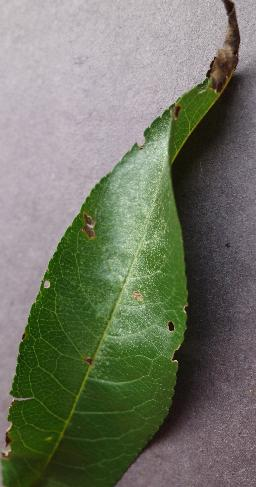

['c_16', '872eaabb-b192-417d-917d-a9a1bc8c8c39___Rut._Bact.S 1068.JPG']


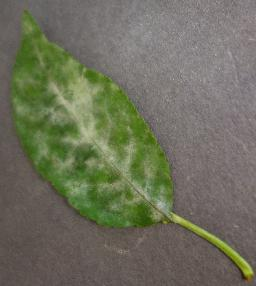

['c_5', 'bda9d7d5-617a-4159-92f2-a30a05396091___FREC_Pwd.M 4924.JPG']


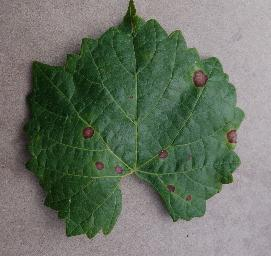

['c_11', '61d82157-b873-457a-ae37-0ed62d6e8c51___FAM_B.Rot 3135.JPG']


In [2]:
rootDir = 'crowdai'
data_root = pathlib.Path(rootDir)
all_image_paths = list(data_root.glob('*/*'))
for i in range(0,3):
    image_example = str(random.choice(all_image_paths))
    display.display(display.Image(image_example))
    print(image_example.split("/")[-2:])
# The first value correspond to folder name and it is its label, next values is the file name

The first value correspond image folder name and it's its label, and next value is the file name

# Load data and create labels

- Create function to read the files in root, and get a list with labels and image names.

After several attempts, and try different aproach, I  choose this way, because the way of dataframe was created keep the same read system order, because the classes or labels are in the same order that jupyter is reading the data, and the code is more clean than other approachs I did tested. I like this consistency, even though the data reading is more slow, but I'm keeping this approach for this work.

In [3]:
def make_labels(rootDir):
    '''
    From a given root, this function return a pandas dataframe with the classes and file names
    The data read is slow but it garanties the order in pandas, as pc read the files.
    inpu:
        rootDir: Root dir which contains the files by classes folder names
    return:
        d: Is an empty dataframe, wich is populated by files names and ist respective classes.
    '''
    df = pd.DataFrame()   
    idx = 0 
    for lists in os.listdir(rootDir): 
        path = os.path.join(rootDir, lists)
        aux_list = []
        for path, dirs, files in os.walk(path):
            key = path.split("/")[-1:][0]
            for file in files:
                temp = pd.DataFrame({'label': key, 'img':file},index=[idx])
                idx +=1
                df = pd.concat([df, temp])
    return df


The next are the function test, in order to get classes and files names from folders.

In [4]:
df = make_labels(rootDir)
df.head()

,label,img
0,c_1,f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE...
1,c_1,73b7ad12-02d0-4775-8f51-c7d404177132___JR_FrgE...
2,c_1,50afe8c7-d56e-4dd0-97b8-23a70ddca819___JR_FrgE...
3,c_1,1ce4ecdf-fe69-42df-a0dc-c90f5495e7a1___JR_FrgE...
4,c_1,464511a6-77d9-493f-bb3c-f151fb390f1b___JR_FrgE...


In [5]:
# Read file function

def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (64, 64), cv2.INTER_LINEAR)
    return resized

In [6]:
# file read checking
path = '../crowdai/c_1/f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE.S 3036.JPG'
a = cv2.imread(path)
a

In [7]:
# Data vectors load function
# source: https://www.kaggle.com/satian/keras-mobilenet-starter

def load_img(df):
    '''
    '''    
    m = df.shape[0]
    X = np.zeros((m, 64, 64, 3))
    count = 0
    for i in range(0,m):
        img = image.load_img(rootDir+"/"+df.ix[i][0]+"/"+df.ix[i][1], target_size=(64, 64, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X[count] = x
        if (count%1000 == 0):
            print("Processing image: ", count+1, ", ", df['img'][i])
        count += 1
    label = list(df)[0]
    values = np.array(df[label])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded    
    
    return X, y, label_encoder
    


## Data drop

As experiment accuracy doesn't improve, this was 0.10 in average.  Maybe it must because data classes are imbalanced, as you can see in the next tables. In order to surpase this, I will try increasing the number of images repeating the numbers of images accord to proportion of the maximum images class.  First, I compute the number of times a class has with respect the maximum number image per class.  Then i will copy many times the class as it is in the minimum number of image in a class.

In [8]:
df_grouped = df.groupby(['label']).count().reset_index().copy().sort_values('img', ascending=False)
df_grouped

,label,img
7,c_15,2321
29,c_35,2100
17,c_24,1917
8,c_16,962
21,c_28,792
18,c_25,749
26,c_32,734
24,c_30,726
27,c_33,720
23,c_3,713


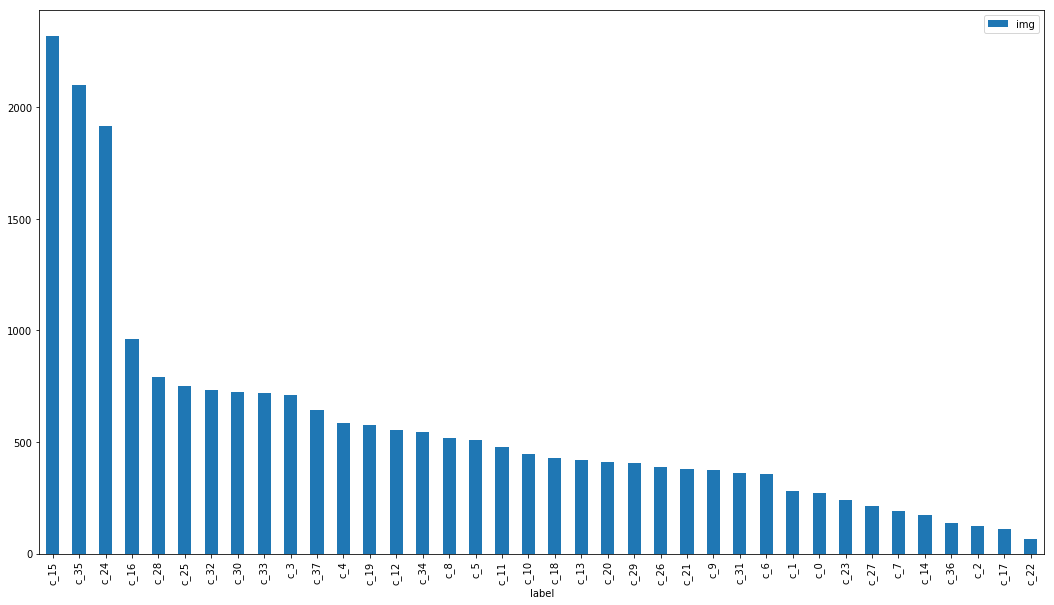

In [9]:
df_grouped.plot.bar(x ='label', figsize=(18,10))

In [10]:
df_grouped.describe()

,img
count,38.000000
mean,576.763158
std,505.201027
min,64.000000
25%,299.500000
50%,436.500000
75%,695.500000
max,2321.000000


The data is completely imbalanced, for that reason, must be find an approach to handle with this imbalances before the feed the Neural network. 

https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

Oversampling with gans

https://github.com/JeffersonLPLima/adversarial_oversampling


https://medium.com/neuralspace/kaggle-1-winning-approach-for-image-classification-challenge-9c1188157a86


https://github.com/kumar-shridhar/CNN_Architectures/blob/master/Resnet50/resnet50.ipynb

I make a copy of dataframe with file data information

In [11]:
k = 300

In [12]:
df2 =pd.DataFrame(columns=['label','img'])
for index,row in df_grouped.iterrows():
    df_aux = df[df.label == row['label']].copy()
    if len(df_aux) > k:
        df_sample = df_aux.sample(n=k).reset_index(drop=True)
    else:
        df_sample = df_aux
    print(df_sample.shape)
    df2 = df2.append(df_sample,ignore_index=True)
    #df_n = pd.concat([df2, df_n_aux],ignore_index=True) 
    print(df2.shape)

    
df2.shape
        #pd.concat([df]*3, ignore_index=True)

(300, 2)
(300, 2)
(300, 2)
(600, 2)
(300, 2)
(900, 2)
(300, 2)
(1200, 2)
(300, 2)
(1500, 2)
(300, 2)
(1800, 2)
(300, 2)
(2100, 2)
(300, 2)
(2400, 2)
(300, 2)
(2700, 2)
(300, 2)
(3000, 2)
(300, 2)
(3300, 2)
(300, 2)
(3600, 2)
(300, 2)
(3900, 2)
(300, 2)
(4200, 2)
(300, 2)
(4500, 2)
(300, 2)
(4800, 2)
(300, 2)
(5100, 2)
(300, 2)
(5400, 2)
(300, 2)
(5700, 2)
(300, 2)
(6000, 2)
(300, 2)
(6300, 2)
(300, 2)
(6600, 2)
(300, 2)
(6900, 2)
(300, 2)
(7200, 2)
(300, 2)
(7500, 2)
(300, 2)
(7800, 2)
(300, 2)
(8100, 2)
(300, 2)
(8400, 2)
(280, 2)
(8680, 2)
(270, 2)
(8950, 2)
(240, 2)
(9190, 2)
(214, 2)
(9404, 2)
(191, 2)
(9595, 2)
(171, 2)
(9766, 2)
(139, 2)
(9905, 2)
(124, 2)
(10029, 2)
(108, 2)
(10137, 2)
(64, 2)
(10201, 2)


(10201, 2)

In [13]:
df2.shape

(10201, 2)

In [14]:
df_grouped2 = df2.groupby(['label']).count().reset_index().copy().sort_values('img', ascending=False)
df_grouped2

,label,img
19,c_26,300
27,c_33,300
21,c_28,300
22,c_29,300
23,c_3,300
24,c_30,300
25,c_31,300
26,c_32,300
28,c_34,300
17,c_24,300


In [15]:
df_grouped2.describe()

,img
count,38.000000
mean,268.447368
std,64.187941
min,64.000000
25%,285.000000
50%,300.000000
75%,300.000000
max,300.000000


In [16]:
X, y, label_encoder = load_img(df2)

Processing image:  1 ,  a6d293f6-5979-475c-96f3-dc64dd2f2d8a___UF.Citrus_HLB_Lab 0188.JPG
Processing image:  1001 ,  8d1daba1-b929-4ffc-bafb-7ca1de1e48e2___Rutg._Bact.S 2143.JPG
Processing image:  2001 ,  a68bc7e8-ac57-4c01-89d3-a53e2cb80480___Matt.S_CG 1536.JPG
Processing image:  3001 ,  00bce074-967b-4d50-967a-31fdaa35e688___RS_HL 0223.JPG
Processing image:  4001 ,  5d1043ef-6d7c-4c8f-9d5b-bfb5b776c828___FAM_B.Msls 0832.JPG
Processing image:  5001 ,  3d8f843b-61ff-425f-9233-00d02606e005___FREC_Pwd.M 4697.JPG
Processing image:  6001 ,  71119c61-edcb-4e12-93ca-4e10ab0c42c7___FAM_L.Blight 1562.JPG
Processing image:  7001 ,  7bb78a67-6fa6-44f2-81ce-26baad680b13___RS_L.Scorch 1426.JPG
Processing image:  8001 ,  0443d006-9d75-4d46-9312-941f21e3791d___Crnl_L.Mold 9139.JPG
Processing image:  9001 ,  eda7f6bf-dc99-4287-a38c-f259e2f21886___Mary_HL 9323.JPG
Processing image:  10001 ,  5c9da5f6-93f9-4fba-8adc-49a6392a7467___FREC_C.Rust 3909.JPG


In [17]:
_, NUM_CLASSES = y.shape
NUM_CLASSES

38

In [18]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123)

In [19]:
# Image Standarization

data_generator = image.ImageDataGenerator(rescale=1./255,
                                          rotation_range=75,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          featurewise_center=True,
                                          featurewise_std_normalization=True,
                                          horizontal_flip=True,
                                          zoom_range=0.3,
                                          samplewise_std_normalization=True)

data_generator.fit(X_train)

# standardize the test set
for i in range(len(X_test)):
    X_test[i] = data_generator.standardize(X_test[i])

## Neural Network Model

In [20]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

The first mode to train is a Resnet 50 with original data.

In [21]:
# Resnet50 model
base_model = ResNet50(input_shape=(64, 64, 3),include_top=False,weights= 'imagenet')

print(base_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________

In [22]:
# https://www.kaggle.com/amadeus1996/fruits-360-transfer-learning-using-keras

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
#x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
# create the full network so we can train on it
inception_transfer = Model(inputs=base_model.input, outputs=predictions)

In [23]:
inception_transfer.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['acc'])

In [24]:
# https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://keras.io/models/sequential/
batch_size=256
epochs = 2500
ini = tm.time()

history =inception_transfer.fit_generator(
    generator=data_generator.flow(x=X_train,
                                  y=y_train,
                                  batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    shuffle = True, 
    verbose = 1,
    validation_data=(X_test, y_test))
end = tm.time()

elapsed = end - ini
print(elapsed/3600)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2500
31/31 [==============================] - 18s 577ms/step - loss: 2.1720 - acc: 0.4866 - val_loss: 0.9329 - val_acc: 0.7526
Epoch 2/2500
31/31 [==============================] - 10s 307ms/step - loss: 1.1223 - acc: 0.6999 - val_loss: 0.7320 - val_acc: 0.7854
Epoch 3/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.8592 - acc: 0.7555 - val_loss: 0.5985 - val_acc: 0.8324
Epoch 4/2500
31/31 [==============================] - 8s 261ms/step - loss: 0.7087 - acc: 0.7898 - val_loss: 0.5569 - val_acc: 0.8447
Epoch 5/2500
31/31 [==============================] - 8s 262ms/step - loss: 0.6551 - acc: 0.8246 - val_loss: 0.4424 - val_acc: 0.8873
Epoch 6/2500
31/31 [==============================] - 8s 263ms/step - loss: 0.5806 - acc: 0.8417 - val_loss: 0.4423 - val_acc: 0.8800
Epoch 7/2500
31/31 [==============================] - 8s 269ms/step - loss: 0.4877 - acc: 0.8573 - val_loss: 0.3731 - val_acc: 0.8927
Epoch 8/2500

31/31 [==============================] - 8s 259ms/step - loss: 0.0671 - acc: 0.9773 - val_loss: 0.1159 - val_acc: 0.9637
Epoch 60/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0756 - acc: 0.9746 - val_loss: 0.0981 - val_acc: 0.9652
Epoch 61/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0691 - acc: 0.9766 - val_loss: 0.1127 - val_acc: 0.9662
Epoch 62/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0611 - acc: 0.9800 - val_loss: 0.1132 - val_acc: 0.9667
Epoch 63/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0600 - acc: 0.9778 - val_loss: 0.1159 - val_acc: 0.9691
Epoch 64/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0614 - acc: 0.9798 - val_loss: 0.1258 - val_acc: 0.9691
Epoch 65/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0600 - acc: 0.9805 - val_loss: 0.0947 - val_acc: 0.9696
Epoch 66/2500
31/31 [==============================] - 8s 258ms/step 

31/31 [==============================] - 8s 259ms/step - loss: 0.0643 - acc: 0.9800 - val_loss: 0.1316 - val_acc: 0.9637
Epoch 120/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0635 - acc: 0.9788 - val_loss: 0.1302 - val_acc: 0.9623
Epoch 121/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0605 - acc: 0.9809 - val_loss: 0.1221 - val_acc: 0.9613
Epoch 122/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0569 - acc: 0.9827 - val_loss: 0.0876 - val_acc: 0.9740
Epoch 123/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0573 - acc: 0.9827 - val_loss: 0.0867 - val_acc: 0.9721
Epoch 124/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0599 - acc: 0.9807 - val_loss: 0.0886 - val_acc: 0.9745
Epoch 125/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0470 - acc: 0.9844 - val_loss: 0.1234 - val_acc: 0.9662
Epoch 126/2500
31/31 [==============================] - 8s 258m

31/31 [==============================] - 8s 258ms/step - loss: 0.1216 - acc: 0.9648 - val_loss: 0.1415 - val_acc: 0.9588
Epoch 180/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.1610 - acc: 0.9654 - val_loss: 0.2487 - val_acc: 0.9446
Epoch 181/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.3596 - acc: 0.9073 - val_loss: 0.3357 - val_acc: 0.9118
Epoch 182/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.2849 - acc: 0.9262 - val_loss: 0.3001 - val_acc: 0.9290
Epoch 183/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.5189 - acc: 0.8725 - val_loss: 0.4911 - val_acc: 0.8760
Epoch 184/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.4142 - acc: 0.8957 - val_loss: 0.3444 - val_acc: 0.9054
Epoch 185/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.3874 - acc: 0.9033 - val_loss: 0.4405 - val_acc: 0.8907
Epoch 186/2500
31/31 [==============================] - 8s 258m

31/31 [==============================] - 8s 259ms/step - loss: 0.0279 - acc: 0.9911 - val_loss: 0.1371 - val_acc: 0.9637
Epoch 240/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0337 - acc: 0.9896 - val_loss: 0.1097 - val_acc: 0.9682
Epoch 241/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0334 - acc: 0.9894 - val_loss: 0.1058 - val_acc: 0.9701
Epoch 242/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0256 - acc: 0.9924 - val_loss: 0.1165 - val_acc: 0.9662
Epoch 243/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0292 - acc: 0.9900 - val_loss: 0.1038 - val_acc: 0.9731
Epoch 244/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0285 - acc: 0.9899 - val_loss: 0.1147 - val_acc: 0.9652
Epoch 245/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0242 - acc: 0.9913 - val_loss: 0.1032 - val_acc: 0.9731
Epoch 246/2500
31/31 [==============================] - 8s 258m

31/31 [==============================] - 8s 258ms/step - loss: 0.2809 - acc: 0.9339 - val_loss: 0.2502 - val_acc: 0.9456
Epoch 300/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.1941 - acc: 0.9570 - val_loss: 0.2563 - val_acc: 0.9505
Epoch 301/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.2106 - acc: 0.9507 - val_loss: 0.2105 - val_acc: 0.9495
Epoch 302/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.1484 - acc: 0.9659 - val_loss: 0.2265 - val_acc: 0.9515
Epoch 303/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.3331 - acc: 0.9182 - val_loss: 0.4481 - val_acc: 0.8878
Epoch 304/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.3321 - acc: 0.9123 - val_loss: 0.2859 - val_acc: 0.9343
Epoch 305/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.1870 - acc: 0.9466 - val_loss: 0.2023 - val_acc: 0.9451
Epoch 306/2500
31/31 [==============================] - 8s 258m

31/31 [==============================] - 8s 259ms/step - loss: 0.0297 - acc: 0.9922 - val_loss: 0.1356 - val_acc: 0.9667
Epoch 360/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0289 - acc: 0.9915 - val_loss: 0.1231 - val_acc: 0.9696
Epoch 361/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0294 - acc: 0.9906 - val_loss: 0.1025 - val_acc: 0.9731
Epoch 362/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0239 - acc: 0.9926 - val_loss: 0.1103 - val_acc: 0.9686
Epoch 363/2500
31/31 [==============================] - 8s 265ms/step - loss: 0.0233 - acc: 0.9925 - val_loss: 0.1185 - val_acc: 0.9691
Epoch 364/2500
31/31 [==============================] - 8s 267ms/step - loss: 0.0185 - acc: 0.9951 - val_loss: 0.1064 - val_acc: 0.9731
Epoch 365/2500
31/31 [==============================] - 8s 265ms/step - loss: 0.0250 - acc: 0.9919 - val_loss: 0.1298 - val_acc: 0.9662
Epoch 366/2500
31/31 [==============================] - 8s 267m

31/31 [==============================] - 8s 259ms/step - loss: 0.0347 - acc: 0.9891 - val_loss: 0.1313 - val_acc: 0.9691
Epoch 420/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0259 - acc: 0.9925 - val_loss: 0.1199 - val_acc: 0.9740
Epoch 421/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0237 - acc: 0.9931 - val_loss: 0.1298 - val_acc: 0.9691
Epoch 422/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0273 - acc: 0.9914 - val_loss: 0.1026 - val_acc: 0.9716
Epoch 423/2500
31/31 [==============================] - 8s 257ms/step - loss: 0.0259 - acc: 0.9918 - val_loss: 0.1090 - val_acc: 0.9691
Epoch 424/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0247 - acc: 0.9918 - val_loss: 0.1308 - val_acc: 0.9686
Epoch 425/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0308 - acc: 0.9911 - val_loss: 0.1074 - val_acc: 0.9750
Epoch 426/2500
31/31 [==============================] - 8s 258m

31/31 [==============================] - 8s 259ms/step - loss: 0.0303 - acc: 0.9910 - val_loss: 0.1051 - val_acc: 0.9716
Epoch 480/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0152 - acc: 0.9946 - val_loss: 0.1298 - val_acc: 0.9672
Epoch 481/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0189 - acc: 0.9947 - val_loss: 0.0899 - val_acc: 0.9770
Epoch 482/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0237 - acc: 0.9938 - val_loss: 0.0918 - val_acc: 0.9780
Epoch 483/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0264 - acc: 0.9925 - val_loss: 0.1002 - val_acc: 0.9765
Epoch 484/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0233 - acc: 0.9930 - val_loss: 0.0894 - val_acc: 0.9740
Epoch 485/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0226 - acc: 0.9928 - val_loss: 0.1060 - val_acc: 0.9731
Epoch 486/2500
31/31 [==============================] - 8s 259m

31/31 [==============================] - 8s 259ms/step - loss: 0.0135 - acc: 0.9956 - val_loss: 0.1262 - val_acc: 0.9750
Epoch 540/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0209 - acc: 0.9948 - val_loss: 0.1397 - val_acc: 0.9740
Epoch 541/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0305 - acc: 0.9914 - val_loss: 0.1316 - val_acc: 0.9716
Epoch 542/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0205 - acc: 0.9926 - val_loss: 0.1479 - val_acc: 0.9706
Epoch 543/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0188 - acc: 0.9942 - val_loss: 0.1243 - val_acc: 0.9780
Epoch 544/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0263 - acc: 0.9923 - val_loss: 0.1358 - val_acc: 0.9691
Epoch 545/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0204 - acc: 0.9941 - val_loss: 0.1153 - val_acc: 0.9750
Epoch 546/2500
31/31 [==============================] - 8s 259m

31/31 [==============================] - 8s 259ms/step - loss: 0.0172 - acc: 0.9954 - val_loss: 0.1041 - val_acc: 0.9755
Epoch 600/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0162 - acc: 0.9957 - val_loss: 0.1120 - val_acc: 0.9740
Epoch 601/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0177 - acc: 0.9946 - val_loss: 0.1030 - val_acc: 0.9765
Epoch 602/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0129 - acc: 0.9958 - val_loss: 0.1261 - val_acc: 0.9740
Epoch 603/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0173 - acc: 0.9940 - val_loss: 0.1304 - val_acc: 0.9682
Epoch 604/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0177 - acc: 0.9937 - val_loss: 0.0943 - val_acc: 0.9794
Epoch 605/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0291 - acc: 0.9923 - val_loss: 0.1336 - val_acc: 0.9667
Epoch 606/2500
31/31 [==============================] - 8s 259m

31/31 [==============================] - 8s 259ms/step - loss: 0.0144 - acc: 0.9953 - val_loss: 0.1127 - val_acc: 0.9740
Epoch 660/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0241 - acc: 0.9942 - val_loss: 0.1249 - val_acc: 0.9691
Epoch 661/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0221 - acc: 0.9934 - val_loss: 0.1338 - val_acc: 0.9696
Epoch 662/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0236 - acc: 0.9936 - val_loss: 0.1116 - val_acc: 0.9696
Epoch 663/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0213 - acc: 0.9942 - val_loss: 0.1464 - val_acc: 0.9633
Epoch 664/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0219 - acc: 0.9928 - val_loss: 0.1337 - val_acc: 0.9735
Epoch 665/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0185 - acc: 0.9934 - val_loss: 0.0999 - val_acc: 0.9765
Epoch 666/2500
31/31 [==============================] - 8s 259m

31/31 [==============================] - 8s 259ms/step - loss: 0.0221 - acc: 0.9951 - val_loss: 0.1135 - val_acc: 0.9726
Epoch 720/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0223 - acc: 0.9947 - val_loss: 0.1191 - val_acc: 0.9731
Epoch 721/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0259 - acc: 0.9927 - val_loss: 0.1469 - val_acc: 0.9647
Epoch 722/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0218 - acc: 0.9944 - val_loss: 0.1064 - val_acc: 0.9731
Epoch 723/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0173 - acc: 0.9949 - val_loss: 0.1002 - val_acc: 0.9731
Epoch 724/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0171 - acc: 0.9952 - val_loss: 0.1201 - val_acc: 0.9731
Epoch 725/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0159 - acc: 0.9945 - val_loss: 0.1073 - val_acc: 0.9784
Epoch 726/2500
31/31 [==============================] - 8s 259m

31/31 [==============================] - 8s 258ms/step - loss: 0.0178 - acc: 0.9948 - val_loss: 0.1672 - val_acc: 0.9701
Epoch 780/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0152 - acc: 0.9961 - val_loss: 0.1357 - val_acc: 0.9731
Epoch 781/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0121 - acc: 0.9965 - val_loss: 0.1272 - val_acc: 0.9750
Epoch 782/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0123 - acc: 0.9958 - val_loss: 0.1131 - val_acc: 0.9760
Epoch 783/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0153 - acc: 0.9953 - val_loss: 0.1141 - val_acc: 0.9780
Epoch 784/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0146 - acc: 0.9958 - val_loss: 0.1236 - val_acc: 0.9731
Epoch 785/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0175 - acc: 0.9954 - val_loss: 0.1401 - val_acc: 0.9745
Epoch 786/2500
31/31 [==============================] - 8s 258m

31/31 [==============================] - 8s 258ms/step - loss: 0.0126 - acc: 0.9963 - val_loss: 0.1216 - val_acc: 0.9726
Epoch 840/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0129 - acc: 0.9961 - val_loss: 0.1066 - val_acc: 0.9750
Epoch 841/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0112 - acc: 0.9967 - val_loss: 0.1325 - val_acc: 0.9721
Epoch 842/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0171 - acc: 0.9948 - val_loss: 0.1276 - val_acc: 0.9765
Epoch 843/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0202 - acc: 0.9949 - val_loss: 0.1407 - val_acc: 0.9731
Epoch 844/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0224 - acc: 0.9949 - val_loss: 0.1303 - val_acc: 0.9750
Epoch 845/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0180 - acc: 0.9958 - val_loss: 0.1564 - val_acc: 0.9706
Epoch 846/2500
31/31 [==============================] - 8s 259m

31/31 [==============================] - 8s 260ms/step - loss: 0.0132 - acc: 0.9959 - val_loss: 0.1552 - val_acc: 0.9662
Epoch 900/2500
31/31 [==============================] - 8s 262ms/step - loss: 0.0197 - acc: 0.9944 - val_loss: 0.1624 - val_acc: 0.9721
Epoch 901/2500
31/31 [==============================] - 8s 262ms/step - loss: 0.0129 - acc: 0.9958 - val_loss: 0.1449 - val_acc: 0.9731
Epoch 902/2500
31/31 [==============================] - 8s 262ms/step - loss: 0.0157 - acc: 0.9962 - val_loss: 0.1093 - val_acc: 0.9794
Epoch 903/2500
31/31 [==============================] - 8s 272ms/step - loss: 0.0132 - acc: 0.9961 - val_loss: 0.1341 - val_acc: 0.9735
Epoch 904/2500
31/31 [==============================] - 8s 267ms/step - loss: 0.0138 - acc: 0.9961 - val_loss: 0.1241 - val_acc: 0.9765
Epoch 905/2500
31/31 [==============================] - 8s 262ms/step - loss: 0.0171 - acc: 0.9960 - val_loss: 0.1358 - val_acc: 0.9750
Epoch 906/2500
31/31 [==============================] - 8s 262m

31/31 [==============================] - 8s 259ms/step - loss: 0.0131 - acc: 0.9963 - val_loss: 0.0907 - val_acc: 0.9799
Epoch 960/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0085 - acc: 0.9976 - val_loss: 0.0948 - val_acc: 0.9814
Epoch 961/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0119 - acc: 0.9970 - val_loss: 0.0757 - val_acc: 0.9784
Epoch 962/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0091 - acc: 0.9969 - val_loss: 0.1057 - val_acc: 0.9789
Epoch 963/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0120 - acc: 0.9968 - val_loss: 0.1166 - val_acc: 0.9775
Epoch 964/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0115 - acc: 0.9974 - val_loss: 0.1207 - val_acc: 0.9775
Epoch 965/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0082 - acc: 0.9978 - val_loss: 0.1241 - val_acc: 0.9750
Epoch 966/2500
31/31 [==============================] - 8s 259m

31/31 [==============================] - 8s 259ms/step - loss: 0.0143 - acc: 0.9963 - val_loss: 0.0997 - val_acc: 0.9775
Epoch 1020/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0104 - acc: 0.9971 - val_loss: 0.1067 - val_acc: 0.9775
Epoch 1021/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0110 - acc: 0.9966 - val_loss: 0.1167 - val_acc: 0.9789
Epoch 1022/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0125 - acc: 0.9961 - val_loss: 0.1261 - val_acc: 0.9755
Epoch 1023/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0081 - acc: 0.9976 - val_loss: 0.1162 - val_acc: 0.9745
Epoch 1024/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0981 - val_acc: 0.9775
Epoch 1025/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0105 - acc: 0.9976 - val_loss: 0.1149 - val_acc: 0.9784
Epoch 1026/2500
31/31 [==============================] - 

Epoch 1079/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0137 - acc: 0.9966 - val_loss: 0.0992 - val_acc: 0.9789
Epoch 1080/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0093 - acc: 0.9971 - val_loss: 0.1095 - val_acc: 0.9780
Epoch 1081/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0124 - acc: 0.9968 - val_loss: 0.1072 - val_acc: 0.9765
Epoch 1082/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0129 - acc: 0.9967 - val_loss: 0.1225 - val_acc: 0.9780
Epoch 1083/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0080 - acc: 0.9974 - val_loss: 0.1092 - val_acc: 0.9775
Epoch 1084/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0091 - acc: 0.9971 - val_loss: 0.1125 - val_acc: 0.9775
Epoch 1085/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0108 - acc: 0.9971 - val_loss: 0.1182 - val_acc: 0.9775
Epoch 1086/2500
31/31 [==================

Epoch 1139/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0165 - acc: 0.9958 - val_loss: 0.1503 - val_acc: 0.9706
Epoch 1140/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0201 - acc: 0.9959 - val_loss: 0.1132 - val_acc: 0.9760
Epoch 1141/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0174 - acc: 0.9952 - val_loss: 0.1325 - val_acc: 0.9711
Epoch 1142/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0130 - acc: 0.9963 - val_loss: 0.1300 - val_acc: 0.9745
Epoch 1143/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0112 - acc: 0.9970 - val_loss: 0.1316 - val_acc: 0.9711
Epoch 1144/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0080 - acc: 0.9976 - val_loss: 0.1437 - val_acc: 0.9731
Epoch 1145/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0149 - acc: 0.9963 - val_loss: 0.1343 - val_acc: 0.9735
Epoch 1146/2500
31/31 [==================

Epoch 1199/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0123 - acc: 0.9968 - val_loss: 0.1547 - val_acc: 0.9716
Epoch 1200/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0076 - acc: 0.9975 - val_loss: 0.1670 - val_acc: 0.9706
Epoch 1201/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0181 - acc: 0.9959 - val_loss: 0.1577 - val_acc: 0.9745
Epoch 1202/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0112 - acc: 0.9972 - val_loss: 0.1477 - val_acc: 0.9735
Epoch 1203/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0140 - acc: 0.9967 - val_loss: 0.1455 - val_acc: 0.9750
Epoch 1204/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0145 - acc: 0.9963 - val_loss: 0.1553 - val_acc: 0.9716
Epoch 1205/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0197 - acc: 0.9958 - val_loss: 0.1394 - val_acc: 0.9731
Epoch 1206/2500
31/31 [==================

Epoch 1259/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0079 - acc: 0.9979 - val_loss: 0.1522 - val_acc: 0.9755
Epoch 1260/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0114 - acc: 0.9975 - val_loss: 0.1429 - val_acc: 0.9789
Epoch 1261/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0108 - acc: 0.9966 - val_loss: 0.1532 - val_acc: 0.9745
Epoch 1262/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0051 - acc: 0.9985 - val_loss: 0.1276 - val_acc: 0.9794
Epoch 1263/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0089 - acc: 0.9980 - val_loss: 0.1169 - val_acc: 0.9770
Epoch 1264/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0050 - acc: 0.9986 - val_loss: 0.1453 - val_acc: 0.9740
Epoch 1265/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0099 - acc: 0.9977 - val_loss: 0.1432 - val_acc: 0.9745
Epoch 1266/2500
31/31 [==================

Epoch 1319/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0073 - acc: 0.9979 - val_loss: 0.1252 - val_acc: 0.9789
Epoch 1320/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0092 - acc: 0.9972 - val_loss: 0.1364 - val_acc: 0.9750
Epoch 1321/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0076 - acc: 0.9977 - val_loss: 0.1459 - val_acc: 0.9735
Epoch 1322/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0092 - acc: 0.9972 - val_loss: 0.1540 - val_acc: 0.9731
Epoch 1323/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0097 - acc: 0.9976 - val_loss: 0.1431 - val_acc: 0.9750
Epoch 1324/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0071 - acc: 0.9976 - val_loss: 0.1303 - val_acc: 0.9745
Epoch 1325/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0078 - acc: 0.9979 - val_loss: 0.1305 - val_acc: 0.9760
Epoch 1326/2500
31/31 [==================

Epoch 1379/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0166 - acc: 0.9958 - val_loss: 0.1454 - val_acc: 0.9740
Epoch 1380/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0083 - acc: 0.9969 - val_loss: 0.1103 - val_acc: 0.9819
Epoch 1381/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0075 - acc: 0.9980 - val_loss: 0.1145 - val_acc: 0.9784
Epoch 1382/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0110 - acc: 0.9970 - val_loss: 0.1431 - val_acc: 0.9735
Epoch 1383/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0172 - acc: 0.9971 - val_loss: 0.1403 - val_acc: 0.9677
Epoch 1384/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0541 - acc: 0.9869 - val_loss: 0.1809 - val_acc: 0.9657
Epoch 1385/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0403 - acc: 0.9910 - val_loss: 0.1850 - val_acc: 0.9696
Epoch 1386/2500
31/31 [==================

Epoch 1439/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0074 - acc: 0.9977 - val_loss: 0.1416 - val_acc: 0.9745
Epoch 1440/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0083 - acc: 0.9973 - val_loss: 0.1265 - val_acc: 0.9794
Epoch 1441/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0097 - acc: 0.9971 - val_loss: 0.1218 - val_acc: 0.9789
Epoch 1442/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0095 - acc: 0.9979 - val_loss: 0.1131 - val_acc: 0.9775
Epoch 1443/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0086 - acc: 0.9976 - val_loss: 0.1353 - val_acc: 0.9775
Epoch 1444/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0081 - acc: 0.9975 - val_loss: 0.1351 - val_acc: 0.9799
Epoch 1445/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0031 - acc: 0.9989 - val_loss: 0.1418 - val_acc: 0.9799
Epoch 1446/2500
31/31 [==================

Epoch 1499/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0085 - acc: 0.9979 - val_loss: 0.1280 - val_acc: 0.9765
Epoch 1500/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0118 - acc: 0.9965 - val_loss: 0.1356 - val_acc: 0.9780
Epoch 1501/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0103 - acc: 0.9981 - val_loss: 0.1145 - val_acc: 0.9824
Epoch 1502/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0101 - acc: 0.9973 - val_loss: 0.1033 - val_acc: 0.9809
Epoch 1503/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0210 - acc: 0.9958 - val_loss: 0.1163 - val_acc: 0.9804
Epoch 1504/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0142 - acc: 0.9968 - val_loss: 0.1134 - val_acc: 0.9755
Epoch 1505/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0146 - acc: 0.9971 - val_loss: 0.0978 - val_acc: 0.9814
Epoch 1506/2500
31/31 [==================

Epoch 1559/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0054 - acc: 0.9986 - val_loss: 0.1464 - val_acc: 0.9765
Epoch 1560/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0050 - acc: 0.9984 - val_loss: 0.1172 - val_acc: 0.9824
Epoch 1561/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.1415 - val_acc: 0.9814
Epoch 1562/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.1382 - val_acc: 0.9794
Epoch 1563/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0065 - acc: 0.9982 - val_loss: 0.1343 - val_acc: 0.9770
Epoch 1564/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0055 - acc: 0.9980 - val_loss: 0.1540 - val_acc: 0.9784
Epoch 1565/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0088 - acc: 0.9979 - val_loss: 0.1472 - val_acc: 0.9770
Epoch 1566/2500
31/31 [==================

Epoch 1619/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0113 - acc: 0.9967 - val_loss: 0.1463 - val_acc: 0.9770
Epoch 1620/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0170 - acc: 0.9964 - val_loss: 0.1763 - val_acc: 0.9696
Epoch 1621/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0097 - acc: 0.9970 - val_loss: 0.1153 - val_acc: 0.9750
Epoch 1622/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0046 - acc: 0.9976 - val_loss: 0.1159 - val_acc: 0.9765
Epoch 1623/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0083 - acc: 0.9985 - val_loss: 0.1158 - val_acc: 0.9784
Epoch 1624/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.1085 - val_acc: 0.9775
Epoch 1625/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0035 - acc: 0.9986 - val_loss: 0.1420 - val_acc: 0.9745
Epoch 1626/2500
31/31 [==================

Epoch 1679/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0101 - acc: 0.9975 - val_loss: 0.1052 - val_acc: 0.9794
Epoch 1680/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0061 - acc: 0.9978 - val_loss: 0.1202 - val_acc: 0.9760
Epoch 1681/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0121 - acc: 0.9971 - val_loss: 0.1219 - val_acc: 0.9716
Epoch 1682/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0079 - acc: 0.9975 - val_loss: 0.1103 - val_acc: 0.9775
Epoch 1683/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0090 - acc: 0.9977 - val_loss: 0.1163 - val_acc: 0.9770
Epoch 1684/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0026 - acc: 0.9989 - val_loss: 0.1186 - val_acc: 0.9775
Epoch 1685/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0040 - acc: 0.9984 - val_loss: 0.1000 - val_acc: 0.9789
Epoch 1686/2500
31/31 [==================

Epoch 1739/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0027 - acc: 0.9989 - val_loss: 0.1208 - val_acc: 0.9809
Epoch 1740/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0050 - acc: 0.9981 - val_loss: 0.1165 - val_acc: 0.9794
Epoch 1741/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0072 - acc: 0.9981 - val_loss: 0.1146 - val_acc: 0.9804
Epoch 1742/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.1196 - val_acc: 0.9804
Epoch 1743/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0106 - acc: 0.9976 - val_loss: 0.1374 - val_acc: 0.9799
Epoch 1744/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0144 - acc: 0.9962 - val_loss: 0.1211 - val_acc: 0.9809
Epoch 1745/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0264 - acc: 0.9954 - val_loss: 0.1154 - val_acc: 0.9755
Epoch 1746/2500
31/31 [==================

Epoch 1799/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0051 - acc: 0.9990 - val_loss: 0.1094 - val_acc: 0.9819
Epoch 1800/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0075 - acc: 0.9979 - val_loss: 0.0895 - val_acc: 0.9843
Epoch 1801/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0055 - acc: 0.9986 - val_loss: 0.1140 - val_acc: 0.9780
Epoch 1802/2500
31/31 [==============================] - 8s 257ms/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.1097 - val_acc: 0.9799
Epoch 1803/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0050 - acc: 0.9982 - val_loss: 0.1152 - val_acc: 0.9789
Epoch 1804/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0075 - acc: 0.9982 - val_loss: 0.1291 - val_acc: 0.9789
Epoch 1805/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0068 - acc: 0.9990 - val_loss: 0.1311 - val_acc: 0.9784
Epoch 1806/2500
31/31 [==================

Epoch 1859/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0065 - acc: 0.9976 - val_loss: 0.1418 - val_acc: 0.9755
Epoch 1860/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0090 - acc: 0.9982 - val_loss: 0.1191 - val_acc: 0.9794
Epoch 1861/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0046 - acc: 0.9984 - val_loss: 0.1435 - val_acc: 0.9780
Epoch 1862/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0058 - acc: 0.9980 - val_loss: 0.1706 - val_acc: 0.9760
Epoch 1863/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0065 - acc: 0.9984 - val_loss: 0.1819 - val_acc: 0.9735
Epoch 1864/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0162 - acc: 0.9956 - val_loss: 0.1663 - val_acc: 0.9726
Epoch 1865/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0176 - acc: 0.9959 - val_loss: 0.1747 - val_acc: 0.9701
Epoch 1866/2500
31/31 [==================

Epoch 1919/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0073 - acc: 0.9987 - val_loss: 0.1437 - val_acc: 0.9740
Epoch 1920/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0172 - acc: 0.9968 - val_loss: 0.1416 - val_acc: 0.9770
Epoch 1921/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0109 - acc: 0.9977 - val_loss: 0.1309 - val_acc: 0.9794
Epoch 1922/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0189 - acc: 0.9958 - val_loss: 0.1135 - val_acc: 0.9819
Epoch 1923/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0168 - acc: 0.9962 - val_loss: 0.0996 - val_acc: 0.9809
Epoch 1924/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0099 - acc: 0.9973 - val_loss: 0.1202 - val_acc: 0.9794
Epoch 1925/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0160 - acc: 0.9974 - val_loss: 0.1047 - val_acc: 0.9809
Epoch 1926/2500
31/31 [==================

Epoch 1979/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0100 - acc: 0.9977 - val_loss: 0.0932 - val_acc: 0.9829
Epoch 1980/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0041 - acc: 0.9984 - val_loss: 0.0826 - val_acc: 0.9824
Epoch 1981/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0106 - acc: 0.9981 - val_loss: 0.0976 - val_acc: 0.9780
Epoch 1982/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0117 - acc: 0.9970 - val_loss: 0.1056 - val_acc: 0.9819
Epoch 1983/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0049 - acc: 0.9989 - val_loss: 0.1061 - val_acc: 0.9799
Epoch 1984/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0091 - acc: 0.9976 - val_loss: 0.1335 - val_acc: 0.9814
Epoch 1985/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0093 - acc: 0.9980 - val_loss: 0.1275 - val_acc: 0.9789
Epoch 1986/2500
31/31 [==================

Epoch 2039/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0110 - acc: 0.9972 - val_loss: 0.1237 - val_acc: 0.9799
Epoch 2040/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.1177 - val_acc: 0.9824
Epoch 2041/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0038 - acc: 0.9991 - val_loss: 0.1172 - val_acc: 0.9824
Epoch 2042/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0043 - acc: 0.9990 - val_loss: 0.0972 - val_acc: 0.9838
Epoch 2043/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0055 - acc: 0.9989 - val_loss: 0.1178 - val_acc: 0.9804
Epoch 2044/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.1329 - val_acc: 0.9775
Epoch 2045/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0056 - acc: 0.9982 - val_loss: 0.1305 - val_acc: 0.9770
Epoch 2046/2500
31/31 [==================

Epoch 2099/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0059 - acc: 0.9988 - val_loss: 0.1186 - val_acc: 0.9794
Epoch 2100/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0028 - acc: 0.9989 - val_loss: 0.1338 - val_acc: 0.9770
Epoch 2101/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0133 - acc: 0.9977 - val_loss: 0.1112 - val_acc: 0.9794
Epoch 2102/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0033 - acc: 0.9986 - val_loss: 0.1050 - val_acc: 0.9819
Epoch 2103/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0056 - acc: 0.9985 - val_loss: 0.1118 - val_acc: 0.9794
Epoch 2104/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0066 - acc: 0.9985 - val_loss: 0.1316 - val_acc: 0.9789
Epoch 2105/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0081 - acc: 0.9985 - val_loss: 0.1315 - val_acc: 0.9809
Epoch 2106/2500
31/31 [==================

Epoch 2159/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0105 - acc: 0.9979 - val_loss: 0.1600 - val_acc: 0.9799
Epoch 2160/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0075 - acc: 0.9976 - val_loss: 0.1378 - val_acc: 0.9814
Epoch 2161/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0124 - acc: 0.9976 - val_loss: 0.1546 - val_acc: 0.9789
Epoch 2162/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0183 - acc: 0.9962 - val_loss: 0.1555 - val_acc: 0.9775
Epoch 2163/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0115 - acc: 0.9971 - val_loss: 0.1785 - val_acc: 0.9735
Epoch 2164/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0158 - acc: 0.9963 - val_loss: 0.1541 - val_acc: 0.9775
Epoch 2165/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0116 - acc: 0.9977 - val_loss: 0.1400 - val_acc: 0.9750
Epoch 2166/2500
31/31 [==================

Epoch 2219/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0086 - acc: 0.9974 - val_loss: 0.1637 - val_acc: 0.9740
Epoch 2220/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0078 - acc: 0.9976 - val_loss: 0.1435 - val_acc: 0.9765
Epoch 2221/2500
31/31 [==============================] - 8s 263ms/step - loss: 0.0057 - acc: 0.9987 - val_loss: 0.1475 - val_acc: 0.9775
Epoch 2222/2500
31/31 [==============================] - 8s 262ms/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.1413 - val_acc: 0.9770
Epoch 2223/2500
31/31 [==============================] - 8s 265ms/step - loss: 0.0057 - acc: 0.9982 - val_loss: 0.1463 - val_acc: 0.9775
Epoch 2224/2500
31/31 [==============================] - 8s 265ms/step - loss: 0.0052 - acc: 0.9989 - val_loss: 0.1562 - val_acc: 0.9770
Epoch 2225/2500
31/31 [==============================] - 8s 265ms/step - loss: 0.0023 - acc: 0.9989 - val_loss: 0.1654 - val_acc: 0.9789
Epoch 2226/2500
31/31 [==================

Epoch 2279/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0136 - acc: 0.9975 - val_loss: 0.1180 - val_acc: 0.9814
Epoch 2280/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0095 - acc: 0.9979 - val_loss: 0.1188 - val_acc: 0.9814
Epoch 2281/2500
31/31 [==============================] - 8s 260ms/step - loss: 0.0106 - acc: 0.9976 - val_loss: 0.1446 - val_acc: 0.9799
Epoch 2282/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0080 - acc: 0.9978 - val_loss: 0.1451 - val_acc: 0.9819
Epoch 2283/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.1359 - val_acc: 0.9809
Epoch 2284/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0099 - acc: 0.9975 - val_loss: 0.1406 - val_acc: 0.9814
Epoch 2285/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0175 - acc: 0.9966 - val_loss: 0.1213 - val_acc: 0.9789
Epoch 2286/2500
31/31 [==================

Epoch 2339/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0047 - acc: 0.9982 - val_loss: 0.1535 - val_acc: 0.9770
Epoch 2340/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0120 - acc: 0.9977 - val_loss: 0.1525 - val_acc: 0.9765
Epoch 2341/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0080 - acc: 0.9983 - val_loss: 0.1842 - val_acc: 0.9745
Epoch 2342/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0052 - acc: 0.9990 - val_loss: 0.1673 - val_acc: 0.9809
Epoch 2343/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0049 - acc: 0.9986 - val_loss: 0.1549 - val_acc: 0.9789
Epoch 2344/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0138 - acc: 0.9970 - val_loss: 0.1510 - val_acc: 0.9780
Epoch 2345/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0075 - acc: 0.9980 - val_loss: 0.1518 - val_acc: 0.9775
Epoch 2346/2500
31/31 [==================

Epoch 2399/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0072 - acc: 0.9987 - val_loss: 0.1975 - val_acc: 0.9716
Epoch 2400/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0054 - acc: 0.9989 - val_loss: 0.1889 - val_acc: 0.9706
Epoch 2401/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0099 - acc: 0.9980 - val_loss: 0.1913 - val_acc: 0.9721
Epoch 2402/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0107 - acc: 0.9970 - val_loss: 0.1652 - val_acc: 0.9740
Epoch 2403/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0106 - acc: 0.9972 - val_loss: 0.1777 - val_acc: 0.9740
Epoch 2404/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0131 - acc: 0.9976 - val_loss: 0.1952 - val_acc: 0.9721
Epoch 2405/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0125 - acc: 0.9977 - val_loss: 0.1677 - val_acc: 0.9770
Epoch 2406/2500
31/31 [==================

Epoch 2459/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0145 - acc: 0.9967 - val_loss: 0.1641 - val_acc: 0.9740
Epoch 2460/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0081 - acc: 0.9975 - val_loss: 0.1487 - val_acc: 0.9755
Epoch 2461/2500
31/31 [==============================] - 8s 258ms/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.1574 - val_acc: 0.9765
Epoch 2462/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0087 - acc: 0.9981 - val_loss: 0.1305 - val_acc: 0.9780
Epoch 2463/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0063 - acc: 0.9985 - val_loss: 0.1375 - val_acc: 0.9760
Epoch 2464/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0078 - acc: 0.9983 - val_loss: 0.1329 - val_acc: 0.9799
Epoch 2465/2500
31/31 [==============================] - 8s 259ms/step - loss: 0.0040 - acc: 0.9990 - val_loss: 0.1395 - val_acc: 0.9780
Epoch 2466/2500
31/31 [==================

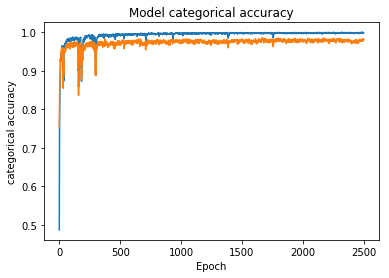

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()